## Housekeeping Settings

In [1]:
import numpy as np, pandas as pd, scanpy as sc, matplotlib.pyplot as plt, os
from scipy.stats import hypergeom
import celloracle as co, glob, pickle
from functools import reduce
import itertools, math, random
import networkx as nx

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'lf_enrich')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"
random.seed(42)

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

In [17]:
# ------------------------------------------------------------
# Functions for building networks and TF lists
# ------------------------------------------------------------
def create_combined_links_for_cluster_fusion(cluster_fusion, links_after_fit):
    # Create combined links and finding threshold for edge strength
    combined_links = pd.DataFrame()
    for cluster in cluster_fusion:
        combined_links_og = links_after_fit[cluster]  # Convert to DataFrame
        combined_links_og['cluster'] = cluster
        combined_links = pd.concat([combined_links, combined_links_og], axis=0)
        combined_links[combined_links['cluster']==cluster]['coef_abs'].plot(kind='hist', bins=20, alpha=0.5)
    threshold = abs(combined_links['coef_abs']).quantile(0.9)
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1)
    return combined_links, threshold

def filter_combined_links_and_build_grn(combined_links,threshold):
    # Filter combined links and create GRN
    combined_links['strength'] = combined_links['coef_abs'].apply(lambda x: 0 if x<threshold else 1)
    grn = nx.MultiDiGraph()
    for _, row in combined_links.iterrows():
        grn.add_edge(
            row['source'],
            row['target'],
            weight=row['coef_mean'],
            cluster=row['cluster'],
            strength=row['strength'],
        )
    edges_df = pd.DataFrame([
        {
            'source': u,
            'target': v,
            'key': k,
            **d
        }
        for u, v, k, d in grn.edges(keys=True, data=True)
        ])
    return grn, edges_df

def filter_network_score_data(cluster_fusion, network_scores):
    combined_network_scores = pd.concat([network_scores[network_scores['cluster'] == int(cluster_id)] for cluster_id in cluster_fusion]) \
                                        .sort_values(by='degree_centrality_out', ascending=False) \
                                        .loc[lambda df: (~df.index.duplicated(keep='first'))]
    return combined_network_scores


In [18]:
# ------------------------------------------------------------
# Functions for doing enrichments
# ------------------------------------------------------------
def enrichment(M,n,N,X):
    # M is the total number of items in the population ===> Total starting genes in SLIDE
    # n is the number of successes in the population ===> Downstream genes
    # N is the sample size ===> Total SLIDE genes in LF
    # X is the number of successes in the sample.
    p_value = 1 - hypergeom.cdf(X-1, M, n, N)   # Compute the p-value for observing X or more successes
    score = math.log2((X/n)/(N/M))
    # print(X,N,n,M)
    return (score, p_value)

def get_SLIDE_GRN_enrichment(cc_dict, order_fr_tfcomb, cluster_fusion, edges_df, total_source, slide_starting_genes, slide_features, case):
    for ord_tf in order_fr_tfcomb:
        possible_TF_combinations = list(itertools.combinations(total_source, ord_tf))
        strnth_cnd_TF_comb = list(itertools.product([0, 1], repeat=ord_tf))
        cc_dict.setdefault(cluster_fusion, {}).setdefault(ord_tf, [])
        for TF_comb in possible_TF_combinations:
            print(f"TF_comb: {TF_comb}")
            # FILTER1: Finding common targets from GRN for the TF_comb
            edges_grouped = edges_df[edges_df['source'].isin(TF_comb)].groupby(['source']).agg(list)
            if edges_grouped.empty:
                print(f"No edges found for TF_comb: {TF_comb}")
                continue
            common_targets_from_grn = set.intersection(*map(set, edges_grouped.target.values))
            for condition in strnth_cnd_TF_comb:
                if len(common_targets_from_grn) == 0:
                    cc_dict[cluster_fusion][ord_tf].append([TF_comb, (condition), (0, 1), ([],[]), case, (pd.DataFrame(),pd.DataFrame())])
                else:
                    # FILTER2: Vectorized filtering on (TF, condition) and common targets
                    filter_df = pd.DataFrame({'source': TF_comb, 'strength': condition})
                    filtered = edges_df.merge(filter_df, on=['source', 'strength'])
                    filtered = filtered[filtered['target'].isin(common_targets_from_grn)]

                    # Keep only targets regulated by all (TF, condition) pairs
                    common_targets = (filtered.groupby('target')[['source', 'strength']].nunique().eq(len(filter_df)).all(axis=1))
                    filtered_edges_df = filtered[filtered['target'].isin(common_targets[common_targets].index)]
                    if filtered_edges_df.empty:
                        cc_dict[cluster_fusion][ord_tf].append([TF_comb, (condition), (0, 1), ([], []), case, (filtered_edges_df, pd.DataFrame())])
                    else:
                        # Drop duplicates based on source and target, keeping the one with the maximum absolute weight
                        filtered_edges_df_unique = filtered_edges_df.loc[filtered_edges_df.groupby(['source', 'target'])['weight'].apply(lambda x: x.abs().idxmax())]
                        dwn_list = list(filtered_edges_df_unique['target'].unique())
                        dwngene = len(dwn_list)
                        # FILTER3: Finding intersection with latent features
                        cmn_list = list(set(filtered_edges_df_unique['target']).intersection(slide_features))
                        common = len(cmn_list)
                        if common == 0:
                            cc_dict[cluster_fusion][ord_tf].append([TF_comb, (condition), (0, 1), ([], [dwn_list]), case, (filtered_edges_df, filtered_edges_df_unique)])
                        else:
                            enrich = enrichment(slide_starting_genes, dwngene, len(slide_features), common)
                            cc_dict[cluster_fusion][ord_tf].append([TF_comb, (condition), enrich, (cmn_list, dwn_list), case, (filtered_edges_df,filtered_edges_df_unique)])
    return cc_dict

def get_combinatorial_control_enrichment(cc_dict, neighbors_dict,TFs,case, slide_features, slide_starting_genes, grn, order_fr_tfcomb, cluster_fusion):
    for ord_tf in order_fr_tfcomb:
        possible_TF_combinations = list(itertools.combinations(TFs, ord_tf))
        cnds_of_int_for_TF_comb = list(itertools.product([0, 1], repeat=ord_tf))
        cc_dict.setdefault(cluster_fusion, {}).setdefault(ord_tf, [])
        for TF_comb in possible_TF_combinations:
            # Step4.1: Performing enrichment analysis
            common_targets_from_grn = reduce(set.intersection, (neighbors_dict[TF] for TF in TF_comb))
            # print(common_targets_from_grn)
            for condition in cnds_of_int_for_TF_comb:
                common, dwngene = 0, 0
                cmn_list, cmn_wt_list, dwn_list, dwn_wt_list = [], [], [], []
                if len(common_targets_from_grn) == 0:
                    cc_dict[cluster_fusion][ord_tf].append([TF_comb, (condition), (0,1), (cmn_list, dwn_list),case])
                else:
                    for target in common_targets_from_grn:
                        # 0 is for weak, 1 is for strong since the weights are classified as [weak, strong]
                        # all(): Ensures that all the conditions hold true for every TF-cond pair.
                        # counts for classified weights should be greater than 0
                        strength_ok_list = []
                        for TF, cond in zip(TF_comb, condition):
                            st_append = False
                            for key in grn[TF][target].keys():
                                if grn[TF][target][key]['strength'] == cond :
                                    st_append = True
                                    break
                            strength_ok_list.append(st_append)
                        # Check if all weights are ok for the target gene
                        strength_ok = all(strength_ok_list)     
                        if strength_ok: 
                            dwngene+=1
                            dwn_list.append(target)
                            # dwn_wt_list.append([grn[TF][target].get(weight, None)[cond] for TF, cond in zip(TF_comb, condition)])
                            if target in slide_features: 
                                common+=1
                                cmn_list.append(target) # enriched in SLIDE LF, increase common
                                # cmn_wt_list.append([grn[TF][target].get(weight, None)[cond] for TF, cond in zip(TF_comb, condition)]) # add the weights of the common targets
                        # If no common targets or no downstream genes, set enrichment to 0, pval to 1
                    enrich = (0, 1) if (dwngene == 0 or common == 0) else enrichment(slide_starting_genes, dwngene, len(slide_features), common)
                    cc_dict[cluster_fusion][ord_tf].append([TF_comb, (condition), enrich, (cmn_list, dwn_list),case])
    return cc_dict


#### Output

In [19]:
# ------------------------------------------------------------
# Functions for optionally generating the dataframe to be saved
# ------------------------------------------------------------
def _create_enrich_df(cc_dict, cluster_fusion, order_of_combination, filter):
    enrichment_df = pd.DataFrame(cc_dict[cluster_fusion][order_of_combination], columns=['TF', 'condition', 'ES', 'Genes', 'case', 'dfs'])
    enrichment_df[['score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common' , 'dwnstrm']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['condition'].isin(filter))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='score', ascending=False)
    non_zero_score_df = (enrichment_df['p_value']<0.05) \
                            & (enrichment_df['dwnstrm'].apply(len)>2) \
                            & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['score']>0)
    enrichment_df.loc[~non_zero_score_df, 'score'] = 0
    return enrichment_df

def create_enrichment_df(cc_dict, cluster_fusion, order_of_combination, filter = None, suffix=None, write = True):
    if order_of_combination ==1 and filter is None:
        filter = [(1,)]
    elif order_of_combination ==2 and filter is None:
        filter = [(1,1), (0,1), (1,0)]
    else:
        raise ValueError("Currently only supports order_of_combination= 1 or 2")
    enrichment_df = _create_enrich_df(cc_dict, cluster_fusion, order_of_combination, filter)
    if write:
        enrichment_df['dfs'] = enrichment_df['dfs'].apply(lambda x: x.to_json() if isinstance(x, pd.DataFrame) else str(x))
        enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enrichment/SLIDE_LF_enriched_{order_of_combination}_TFs_{cluster_fusion}{suffix}.csv", index=False)
    return enrichment_df

#### Input

In [33]:
# ------------------------------------------------------------
# Functions for reading in the data
# ------------------------------------------------------------
def fetch_GRN_data(GRN_wd):
    # Read oracle links after fitting
    oracle = co.load_hdf5(f"{GRN_wd}/out_data/grn_inference/out_files/oracle_fitted.celloracle.oracle")
    GRN_network_scores = pd.read_csv(f"{GRN_wd}/out_data/grn_inference/out_files/ridge_fitted_2_merged_network_scores.csv", index_col=0)
    GRN_TFs = oracle.all_regulatory_genes_in_TFdict
    GRN_links_after_fit = {key: [] for key in oracle.coef_matrix_per_cluster.keys()}
    for cluster in oracle.coef_matrix_per_cluster.keys():
        cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
        cluster_specific_links.columns = ['source', 'target', 'coef_mean']
        cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
        cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
        GRN_links_after_fit[cluster] = cluster_specific_links
        # links_after_fit[cluster]['weight'] = links_after_fit[cluster]['coef_abs'] * links_after_fit[cluster]['-logp']
        # GRN_TFs = GRN_TFs + list(links_after_fit[cluster].source.unique())
    return GRN_links_after_fit, GRN_network_scores, GRN_TFs

def read_slide_data(experiment, wd):
    # Read SLIDE data for the experiment
    feature_files = glob.glob(f"{wd}/out_data/out_other_methods/SLIDE_Runs/{experiment}/*/*feature_list*")
    feature_data = [pd.read_csv(file, sep='\t', header = 0) for file in feature_files]
    feature_data = pd.concat(feature_data)
    slide_features = set(feature_data['names'])
    return slide_features

#### Create input dictionary for the experiments
input_dict = {
    'experiment': ['PRDM1_KO', 'IRF4_KO', 'GC_PB', 'PB_ABC', 'GC_ABC'],
    'slide_starting_genes': [4472, 4500, 4725, 3420, 4603],
    'clusters_of_interest': [['1','2','3','7'], ['1','2','3','7'], ['7','3'], ['1','7'], ['1','3']],
    'order_fr_clust': [[1], [1], [2], [2], [2]],
    'order_fr_tfcomb': [[1], [1], [1], [2], [2]],
    'weight': ['strength', 'strength', 'strength', 'strength', 'strength'],
}
input_df = pd.DataFrame(input_dict)

#### Assign the input parameters
i=2
experiment = input_df['experiment'][i]
slide_starting_genes = input_df['slide_starting_genes'][i]
clusters_of_interest = input_df['clusters_of_interest'][i]
order_fr_clust = input_df['order_fr_clust'][i]
order_fr_tfcomb = input_df['order_fr_tfcomb'][i]
weight = input_df['weight'][i]

# ------------------------------------------------------------
# Reading the data
# ------------------------------------------------------------
#Read the GRN data and slide features
GRN_wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor'
GRN_links_after_fit, GRN_network_scores, GRN_TFs = fetch_GRN_data(GRN_wd)
slide_features = read_slide_data(experiment, wd)
cluster_fusions = []
for ord_clus in order_fr_clust:
    cluster_fusions += list(itertools.combinations(clusters_of_interest, ord_clus))

TF_comb: ('HES1',)
TF_comb: ('JARID2',)
TF_comb: ('NFAT5',)
TF_comb: ('IRF1',)
TF_comb: ('CIITA',)
TF_comb: ('RUNX1',)
TF_comb: ('BBX',)
TF_comb: ('KLF7',)
TF_comb: ('ZNF652',)
TF_comb: ('PHF21A',)
TF_comb: ('CD74',)
TF_comb: ('ZFHX3',)
TF_comb: ('TFDP2',)
TF_comb: ('FOSB',)
TF_comb: ('HIC2',)
TF_comb: ('PLAGL1',)
TF_comb: ('NR4A1',)
TF_comb: ('ZNF639',)
TF_comb: ('ATF3',)
TF_comb: ('FOS',)
TF_comb: ('ZNF644',)
TF_comb: ('L3MBTL4',)
TF_comb: ('RUNX2',)
TF_comb: ('ZBTB4',)
TF_comb: ('CTNNB1',)
TF_comb: ('NR1D2',)
TF_comb: ('DCP1A',)
TF_comb: ('EGR3',)
TF_comb: ('BATF',)
TF_comb: ('ZNF394',)
TF_comb: ('NR6A1',)
TF_comb: ('TCF12',)
TF_comb: ('MYBL1',)
TF_comb: ('ZEB2',)
TF_comb: ('TGIF1',)
TF_comb: ('KLF8',)
TF_comb: ('BACH1',)
TF_comb: ('ESR2',)
TF_comb: ('ZNF618',)
TF_comb: ('NFKB1',)
TF_comb: ('HBP1',)
TF_comb: ('NR4A3',)
TF_comb: ('BHLHE41',)
TF_comb: ('TFE3',)
TF_comb: ('STAT1',)
TF_comb: ('TCF4',)
TF_comb: ('KDM5B',)
TF_comb: ('RFX3',)
TF_comb: ('TET3',)
TF_comb: ('EGR1',)
TF_comb: 

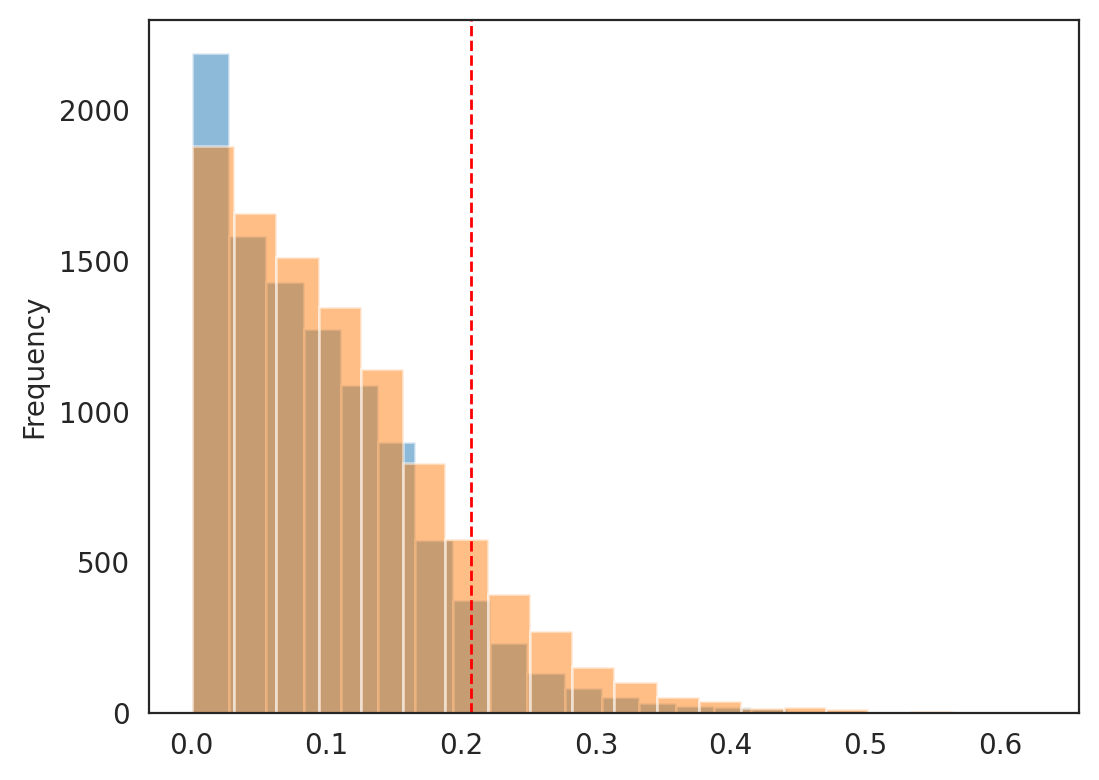

In [38]:
cc_dict = {}
for cluster_fusion in cluster_fusions:
    combined_links, threshold = create_combined_links_for_cluster_fusion(cluster_fusion, GRN_links_after_fit)
    grn, edges_df = filter_combined_links_and_build_grn(combined_links, threshold)
    # ------------------------------------------------------------
    # Creating the TF lists
    # ------------------------------------------------------------
    # Filter SLIDE data wrt GRN, since SLIDE and CO gene sets are not same
    slide_features = slide_features.intersection(set(grn.nodes)) 
    slide_features_neighbors = []
    for gene in slide_features:
        slide_features_neighbors += list(grn.predecessors(gene))
    slide_tot_TF = (slide_features.union(set(slide_features_neighbors))).intersection(GRN_TFs)
    # Read network scores
    combined_network_scores = filter_network_score_data(cluster_fusion, GRN_network_scores)
    combined_network_scores = combined_network_scores[combined_network_scores.index .isin(list(grn.nodes))] # Since SLIDE and CO gene sets are not same
    combined_network_scores = combined_network_scores[combined_network_scores.index .isin(GRN_TFs)] # Since I want to pick size matched set of TFs only
    #### Choosing size matched set of TFs from network and random
    net_match_TF = list(combined_network_scores.index[:len(slide_tot_TF)])
    net_rnd_TF = random.sample(set(GRN_TFs).intersection(set(grn.nodes)), len(slide_tot_TF))
    # write the TFs to file as separate csvs
    pd.DataFrame(slide_tot_TF).to_csv(f"{out_path}/out_files/SLIDE_LF_{cluster_fusion}_{experiment}.csv", index=False)
    pd.DataFrame(net_match_TF).to_csv(f"{out_path}/out_files/Net_match_{cluster_fusion}_{experiment}.csv", index=False)
    pd.DataFrame(net_rnd_TF).to_csv(f"{out_path}/out_files/Net_rnd_{cluster_fusion}_{experiment}.csv", index=False)

    # ------------------------------------------------------------
    # Finally doing enrichments
    # ------------------------------------------------------------
    # Step1: Creating the dictionary of TFs and their neighbors to get the targets from GRN
    # neighbors_dict, cc_dict = {}, {}
    all_TFs = set(slide_tot_TF).union(set(net_match_TF)).union(set(net_rnd_TF))
    # for TF in all_TFs:
    #     if TF not in list(grn.nodes):
    #         print(f"{TF} not in grn")
    #         neighbors_dict[TF] = set()
    #         continue
    #     else:
    #         neighbors_dict[TF] = set(grn[TF].keys())
    # Step2: Finding TF combinations which are enriched in the GRN for list of TFs
    cases = [(slide_tot_TF, 'slide'),(net_match_TF, 'net'),(net_rnd_TF, 'rnd')]
    for TFs, case in cases:
        # Step3: Performing enrichment analysis
        cc_dict = get_SLIDE_GRN_enrichment(cc_dict, order_fr_tfcomb, cluster_fusion, edges_df, TFs, slide_starting_genes, slide_features, case)
    # ------------------------------------------------------------
    # Optionally generating the dataframe to be saved
    # ------------------------------------------------------------
    for ord_tf in order_fr_tfcomb:
        print(f"Creating enrichment dataframe for {experiment}, {cluster_fusion}, {ord_tf} TFs")
        enrichment_df= create_enrichment_df(cc_dict, cluster_fusion, order_of_combination=ord_tf, filter = None, suffix = f"_{experiment}")
        print(enrichment_df['case'].value_counts())
        # dumping the dictionary to pickle file
        with open(f"{out_path}/out_files/SLIDE_LF_enrichment/cc_dict_{experiment}_{cluster_fusion}_{ord_tf}_TFs.pickle", 'wb') as f:
            pickle.dump(cc_dict, f)



#### Plotting enrichment

In [40]:
enrichment_df

,TF,condition,case,dfs,score,p_value,common,dwnstrm
0,"('PRDM1',)","(1,)",net,( source target key weight cluster stre...,6.335734,0.000198,"['IQGAP2', 'RUNX2']","['COBLL1', 'IQGAP2', 'RUNX2']"
1,"('PRDM1',)","(1,)",rnd,( source target key weight cluster stre...,6.335734,0.000198,"['IQGAP2', 'RUNX2']","['COBLL1', 'IQGAP2', 'RUNX2']"
2,"('PRDM1',)","(1,)",slide,( source target key weight cluster stre...,6.335734,0.000198,"['IQGAP2', 'RUNX2']","['COBLL1', 'IQGAP2', 'RUNX2']"
3,"('BACH2',)","(1,)",net,( source target key weight cluster stre...,5.920696,0.000010,"['XBP1', 'MZB1', 'JCHAIN']","['FCRL2', 'JCHAIN', 'MZB1', 'PARP14', 'SDF2L1'..."
4,"('BACH2',)","(1,)",slide,( source target key weight cluster stre...,5.920696,0.000010,"['XBP1', 'MZB1', 'JCHAIN']","['FCRL2', 'JCHAIN', 'MZB1', 'PARP14', 'SDF2L1'..."
...,...,...,...,...,...,...,...,...
428,"('NR4A3',)","(1,)",net,( source target key weight cluster st...,0.000000,1.000000,[],"[['ATXN1', 'ERCC6', 'GAS7', 'HSP90AB1', 'KLF12..."
429,"('CREB5',)","(1,)",net,"(Empty DataFrame\nColumns: [source, target, ke...",0.000000,1.000000,[],[]
430,"('PTEN',)","(1,)",rnd,( source target key weight cluster s...,0.000000,0.709941,['PAX5'],"['AFF1', 'AICDA', 'AKT3', 'ALOX5', 'ANTXR2', '..."
431,"('PTEN',)","(1,)",net,( source target key weight cluster s...,0.000000,0.709941,['PAX5'],"['AFF1', 'AICDA', 'AKT3', 'ALOX5', 'ANTXR2', '..."


In [39]:
ord_tf = 1
enrichment_df= pd.read_csv("/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/lf_enrich/out_files/SLIDE_LF_enrichment/SLIDE_LF_enriched_1_TFs_('7', '3')_GC_PB.csv")
slide_scores = enrichment_df[enrichment_df['case'] == 'slide']['score']
net_scores = enrichment_df[enrichment_df['case'] == 'net']['score']
rnd_scores = enrichment_df[enrichment_df['case'] == 'rnd']['score']

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

def cliffs_delta(x, y):
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return (2 * u) / (n1 * n2) - 1

def compare_nonzero(x, y):
    x_nz, y_nz = x[x != 0], y[y != 0]
    if len(x_nz) == 0 or len(y_nz) == 0:
        return np.nan, np.nan
    u, p = mannwhitneyu(x_nz, y_nz, alternative='two-sided')
    delta = cliffs_delta(x_nz, y_nz)
    return p, delta

def nonzero_rate(x):
    return np.count_nonzero(x) / len(x)

def compare_distributions(slide, net, rnd):
    groups = {'slide': slide, 'net': net, 'rnd': rnd}
    results = []

    pairs = [('slide', 'net'), ('slide', 'rnd'), ('net', 'rnd')]

    for a, b in pairs:
        x, y = groups[a], groups[b]
        p, delta = compare_nonzero(x, y)
        nz_x, nz_y = nonzero_rate(x), nonzero_rate(y)
        mean_nz = np.min([nz_x, nz_y])
        weighted_delta = delta * mean_nz if not np.isnan(delta) else np.nan
        results.append({
            'Group A': a,
            'Group B': b,
            'Size A': len(x),
            'Size B': len(y),
            'Non-zero A': np.count_nonzero(x),
            'Non-zero B': np.count_nonzero(y),
            'Non-zero Rate A': round(nz_x, 4),
            'Non-zero Rate B': round(nz_y, 4),
            'Mann–Whitney p': round(p, 4) if p is not None else np.nan,
            "Cliff's delta": round(delta, 4) if delta is not None else np.nan,
            'Weighted delta': round(weighted_delta, 4) if weighted_delta is not None else np.nan
        })

    return pd.DataFrame(results)

summary = compare_distributions(slide_scores, net_scores, rnd_scores)
print(f"Combinatorial control for {experiment} and {cluster_fusion} and {ord_tf} TFs")
print(summary)

Combinatorial control for GC_PB and ('7', '3') and 1 TFs
  Group A Group B  Size A  Size B  Non-zero A  Non-zero B  Non-zero Rate A  \
0   slide     net     146     146          15          15           0.1027   
1   slide     rnd     146     141          15           9           0.1027   
2     net     rnd     146     141          15           9           0.1027   

   Non-zero Rate B  Mann–Whitney p  Cliff's delta  Weighted delta  
0           0.1027          1.0000         0.0000          0.0000  
1           0.0638          0.6541         0.1185          0.0076  
2           0.0638          0.6541         0.1185          0.0076  
